In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import h5py

hf = h5py.File("/Users/abletimin/cernbox/b-tagg/btagging-ml_tutorial_files/MC16d_ttbar-test-validation_sample-NN.h5", 'r')
print(hf.keys())
X_test, Y_test = hf['X_test'][:100], hf['Y_test'][:100]
hf.close() 

<KeysViewHDF5 ['X_test', 'X_trk_test', 'Y_test', 'labels', 'pt_eta']>


In [2]:
print("Total number of events: ",len(X_test) )

Total number of events:  100


## Load trained mode

This model is trainin on kaggle.  

In [3]:
DL1_model = tf.keras.models.load_model("DL1_tutorial_on_kaggle.h5")
DL1_model.summary()

DL1_half_dropout_rate = tf.keras.models.load_model("DL1_tutorial_on_kaggle.h5")
dropout_layers = ['drop%s'%i for i in range(2,8)]

for layer in DL1_half_dropout_rate.layers:
    
    if layer.name == 'drop1':
        layer.rate = 0.05
    elif layer.name in dropout_layers:
        layer.rate = 0.1

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 44)]              0         
_________________________________________________________________
dense0 (Dense)               (None, 72)                3240      
_________________________________________________________________
BN0 (BatchNormalization)     (None, 72)                288       
_________________________________________________________________
activ0 (Activation)          (None, 72)                0         
_________________________________________________________________
drop0 (Dropout)              (None, 72)                0         
_________________________________________________________________
dense1 (Dense)               (None, 57)                4161      
_________________________________________________________________
BN1 (BatchNormalization)     (None, 57)                228   

## test model with single input

evaluate a single input 10000 times, with dropout.

In [4]:
def DL1_socre(pb, pc, pl): 
    return np.log(pb/(0.018*pc + 0.982*pl))

def plot_prob_score_from_model(event, model):
    
    Single_Pred_prob = model(np.array(10000*[X_test[event,:]]))
    pb = Single_Pred_prob[:,2].numpy()
    pc = Single_Pred_prob[:,1].numpy()
    pl = Single_Pred_prob[:,0].numpy()
    print("true label: ", Y_test[event])
    print("softmax prob: ", Single_Pred_prob[event])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    _n, bins, _ = ax1.hist(pb, bins=50, range=(0,1),  alpha=0.5, label="p_b")
    _ = ax1.hist(pc, bins=bins,  alpha=0.5, label="p_c")
    _ = ax1.hist(pl, bins=bins,  alpha=0.5, label="p_l")
    ax1.legend(loc="upper right")
    
    _ =ax2.hist(DL1_socre(pb, pc, pl), 100,  alpha=0.6)

true label:  [1. 0. 0.]
softmax prob:  tf.Tensor([0.61120546 0.32360315 0.06519139], shape=(3,), dtype=float32)


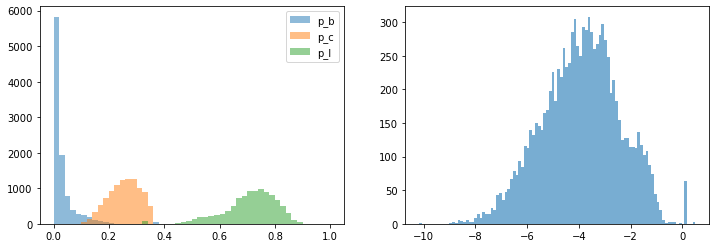

In [5]:
plot_prob_score_from_model(event=10, model=DL1_model)


true label:  [1. 0. 0.]
softmax prob:  tf.Tensor([0.62578064 0.31801042 0.05620888], shape=(3,), dtype=float32)


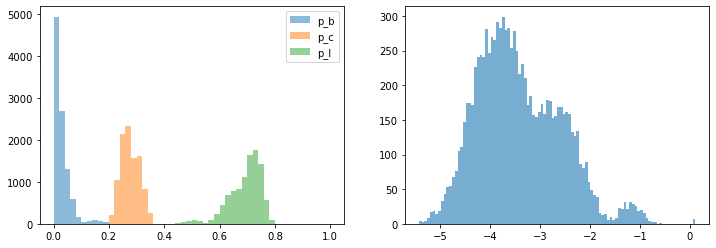

In [6]:
plot_prob_score_from_model(event=10, model=DL1_half_dropout_rate)

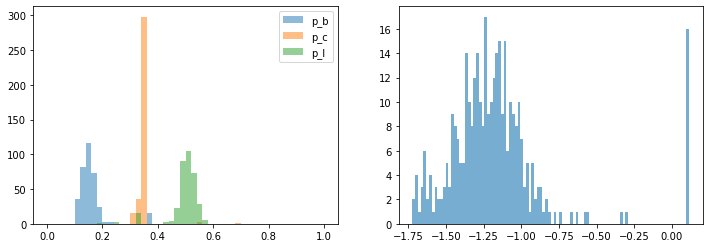

In [7]:
event = 10
Pred_prob = DL1_half_dropout_rate(np.array(10000*[X_test[event,:]]))

pb = Pred_prob[:,2].numpy()
pc = Pred_prob[:,1].numpy()
pl = Pred_prob[:,0].numpy()

pb_filter = pb>0.1
pb = pb[pb_filter]
pc = pc[pb_filter]
pl = pl[pb_filter]

def plot_prob_score(pb, pc, pl, DL1_socre):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    _n, bins, _ = ax1.hist(pb, bins=50, range=(0,1), alpha=0.5, label="p_b")
    _ = ax1.hist(pc, bins=bins, alpha=0.5, label="p_c")
    _ = ax1.hist(pl, bins=bins, alpha=0.5, label="p_l")
    ax1.legend(loc="upper right")
    
    _ =ax2.hist(DL1_socre(pb, pc, pl), 100, alpha=0.6)
    
plot_prob_score(pb, pc, pl, DL1_socre)

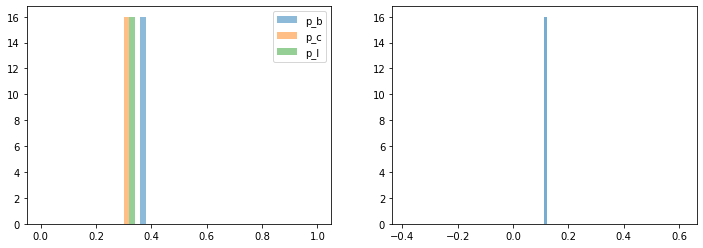

In [9]:
dl1_score = DL1_socre(pb, pc, pl)
pb_filter = dl1_score>0.0
pb = pb[pb_filter]
pc = pc[pb_filter]
pl = pl[pb_filter]

plot_prob_score(pb, pc, pl, DL1_socre)

In [10]:
print(pb)

[0.36675128 0.36675128 0.36675128 0.36675128 0.36675128 0.36675128
 0.36675128 0.36675128 0.36675128 0.36675128 0.36675128 0.36675128
 0.36675128 0.36675128 0.36675128 0.36675128]


## train with small dropout rate 

* train with small dropout rate, and use 2X dropout rate for testing

In [17]:
DL1_model = tf.keras.models.load_model("DL1_tutorial_on_kaggle_halfDropoutRate.h5")
DL1_model.summary()

DL1_2X_dropout_rate = tf.keras.models.load_model("DL1_tutorial_on_kaggle_halfDropoutRate.h5")
dropout_layers = ['drop%s'%i for i in range(2,8)]

for layer in DL1_2X_dropout_rate.layers:
    
    if layer.name == 'drop1':
        layer.rate = 0.5*layer.rate
    elif layer.name in dropout_layers:
        layer.rate = 0.5*layer.rate

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 44)]              0         
_________________________________________________________________
dense0 (Dense)               (None, 72)                3240      
_________________________________________________________________
BN0 (BatchNormalization)     (None, 72)                288       
_________________________________________________________________
activ0 (Activation)          (None, 72)                0         
_________________________________________________________________
drop0 (Dropout)              (None, 72)                0         
_________________________________________________________________
dense1 (Dense)               (None, 57)                4161      
_________________________________________________________________
BN1 (BatchNormalization)     (None, 57)                228   

true label:  [1. 0. 0.]
softmax prob:  tf.Tensor([0.76381326 0.22393642 0.01225032], shape=(3,), dtype=float32)


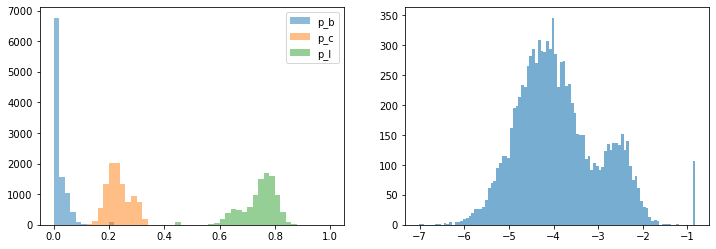

In [18]:
plot_prob_score_from_model(event=10, model=DL1_model)

true label:  [1. 0. 0.]
softmax prob:  tf.Tensor([0.76511943 0.22288123 0.01199932], shape=(3,), dtype=float32)


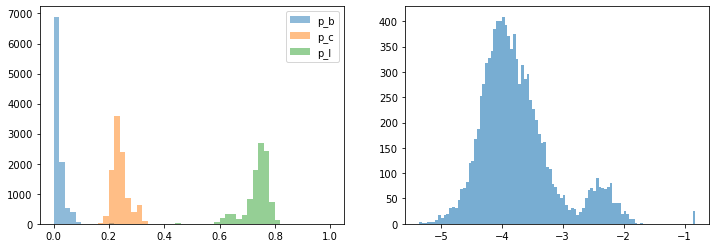

In [19]:
plot_prob_score_from_model(event=10, model=DL1_2X_dropout_rate)